# **Machine Learning: Project Part 1**

---

**Author: Damien Farrell**

---

In [1]:
# Imports

import os
import gc
import torch
import whisper
import whisperx
import pandas as pd
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import pipeline as transformers_pipeline
from pyannote.audio import Pipeline as AudioPipeline
from pyannote.audio.pipelines.utils.hook import ProgressHook

sns.set_theme()

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


I picked a random football podcast clips to analyse as this would have people speaking over each other which would be a difficult test for the model. Unfortunately there was no women included in this clip.

In the `research` folder the Trump Harris debate is analysed.

In [2]:
# Environment Variables
load_dotenv()
HF_API_KEY = os.getenv("HF_API_KEY")
assert HF_API_KEY, "Please set your Hugging Face API key in the HF_API_KEY environment variable."

# Audio File Path
#AUDIO_FILE_PATH = "./audio/TrumpHarrisDebate.wav"
AUDIO_FILE_PATH = "./audio/The Overlap ON TOUR! 4.mp3"
assert AUDIO_FILE_PATH, "Please place your audio in a folder called 'audio'. Note: use backslashes if on Windows"

## **Project Part 1: Audio Analysis**

> 1. **Performs Speaker Diarisation Analysis**  
>    - Uses pre-built models to identify who spoke and when.  
>    - Outputs time segments for each speaker and calculates total speaking time.
> <br><br>
> 2. **Performs Speech to Text Analysis**  
>    - Transcribes the audio for each speaker.  
>    - Combines speaker labels with the transcript (e.g., “[Speaker 1] …”).
> <br><br>
> 3. **Leverage a Large Language Model**
>    - Once the transcript is annotated, the notebook can query a large language model for analysis.
>    - Could identify speaker names and sentiment based on transcript content.
> <br><br>
> 4. **Testing & Evaluation**  
>    - An audio file provided for initial testing.  
>    - The performance of each component should be documented and assessed.
> <br><br>


---

### **1. Performs Speaker Diarisation Analysis** 

---

Using pyannote [1][2]

In [3]:
# instantiate the pipeline
pipeline = AudioPipeline.from_pretrained(
  "pyannote/speaker-diarization-3.1",
  use_auth_token="HF_API_KEY")

In [4]:
# run the pipeline on an audio file
with ProgressHook() as hook:
    diarisation = pipeline(AUDIO_FILE_PATH, hook=hook)

segmentation         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:04
speaker_counting     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
embeddings           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:03:42
discrete_diarization ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

In [5]:
print(diarisation)

[ 00:00:01.448 -->  00:00:04.519] A SPEAKER_08
[ 00:00:04.519 -->  00:00:05.920] B SPEAKER_11
[ 00:00:05.920 -->  00:00:05.937] C SPEAKER_08
[ 00:00:05.937 -->  00:00:16.754] D SPEAKER_11
[ 00:00:05.954 -->  00:00:06.865] E SPEAKER_08
[ 00:00:16.754 -->  00:00:16.872] F SPEAKER_06
[ 00:00:16.872 -->  00:00:17.513] G SPEAKER_11
[ 00:00:17.513 -->  00:00:22.879] H SPEAKER_06
[ 00:00:22.879 -->  00:00:28.364] I SPEAKER_07
[ 00:00:22.964 -->  00:00:23.402] J SPEAKER_06
[ 00:00:26.811 -->  00:00:26.828] K SPEAKER_12
[ 00:00:26.828 -->  00:00:26.845] L SPEAKER_06
[ 00:00:26.845 -->  00:00:27.739] M SPEAKER_12
[ 00:00:28.077 -->  00:00:28.195] N SPEAKER_12
[ 00:00:28.364 -->  00:00:36.059] O SPEAKER_12
[ 00:00:36.396 -->  00:00:38.134] P SPEAKER_12
[ 00:00:39.923 -->  00:00:41.003] Q SPEAKER_12
[ 00:00:41.357 -->  00:00:41.374] R SPEAKER_12
[ 00:00:41.374 -->  00:00:42.522] S SPEAKER_05
[ 00:00:52.697 -->  00:00:54.267] T SPEAKER_00
[ 00:00:54.942 -->  00:00:57.051] U SPEAKER_13
[ 00:01:01.05

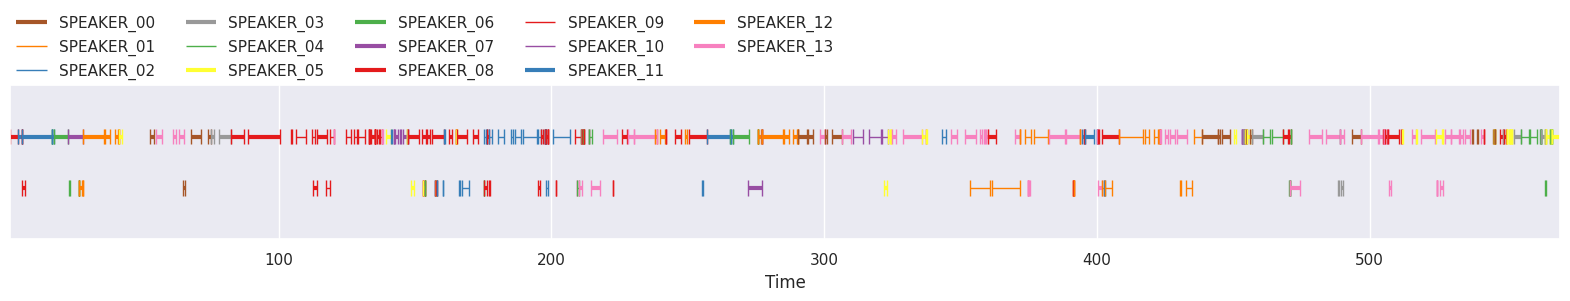

In [6]:
diarisation.support()

---

### **2. Performs Speech to Text Analysis** 

---

Using Whisper [3]

In [7]:
model = whisper.load_model("base.en")
result = model.transcribe(AUDIO_FILE_PATH, verbose=False, fp16=False)
transcript = result["text"]

/home/damien/Documents/ATU/machine-learning-project-1/.venv/lib/python3.12/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = 

In [8]:
print(transcript)

 The overlap on tour is brought to you by Skybat. Even that time, Roy, when you chased down Durr's, so you didn't put a hand on him, did you? No, no, no. I didn't think it was that bad at the time. You think you're just fighting your corner, and then you look and you go, the picture looks bad, don't you? It does. I think someone were, like, edited. That's sure. No, that's where my children's laid. Well, I got right up next to him. I didn't move on that porch. You were in here on the overlap. My hand. Roy key did not chase down Andy Durr's, so it's fussed up. No, I did. I did. I did. I did. It's still photographs, look, because I like where my van is popping out of my head. You put your photo shop 20 years ago. Yeah. Look, of course it was. Ew. As you know, it was behind it. Well, I guess so. Rhea, Rhea, Rhea, Rhea, Rhea, Rhea. Roy, good to be home. Good, good, good. I'm from home. This is Dublin. I'm from Carp. Oh, sorry. Oh, it's good to be back in Ireland, yeah. Yes. Carol, what abou

#### **Combining Speaker Diarisation and Transcript**

I need to use a github repo called Whisper X in order to merge the speaker diarisation and the transcript. [6]

In [9]:
device = "cpu" 
audio_file = AUDIO_FILE_PATH
batch_size = 4 # reduce if low on GPU mem
compute_type = "int8" # change to "int8" if low on GPU mem (may reduce accuracy)
audio = whisperx.load_audio(AUDIO_FILE_PATH)

I am probably not being efficient here and re-processing the file again with WhisperX.

In [10]:
# Align whisper output
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False) # after alignment

Failed to align segment (" It's still photograph, so, because I like where here,"): backtrack failed, resorting to original...
Failed to align segment (" 2004."): no characters in this segment found in model dictionary, resorting to original...


In [11]:
# Assign speaker labels
diarize_model = whisperx.DiarizationPipeline(use_auth_token=HF_API_KEY, device=device)
diarize_segments = diarize_model(audio)
result = whisperx.assign_word_speakers(diarize_segments, result) # segments are now assigned speaker IDs

/home/damien/Documents/ATU/machine-learning-project-1/.venv/lib/python3.12/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)


In [12]:
for seg in result["segments"]:
    # if no words, skip or assign "UNKNOWN"
    if not seg.get("words"):
        seg["speaker"] = "UNKNOWN_SPEAKER"
        continue
    # gather all word-level speakers
    speakers = [word.get("speaker", "UNKNOWN_SPEAKER") for word in seg["words"]]
    # pick the most frequent speaker in this segment
    seg["speaker"] = Counter(speakers).most_common(1)[0][0]

In [13]:
def format_conversation(conversation_dict):
    lines = []
    for segment in conversation_dict["segments"]:
        speaker = segment.get("speaker", "UNKNOWN_SPEAKER")
        text = segment["text"].strip()
        lines.append(f"[{speaker}] {text}")
    return "\n".join(lines)

In [14]:
conversation = format_conversation(result)
print(conversation)

[SPEAKER_10] The overlap on tour is brought to you by Skybat.
[SPEAKER_07] Even that time, Roy, when you chased down Durr's,
[SPEAKER_07] so you didn't put a hand on him, did you?
[SPEAKER_07] No, no, no.
[SPEAKER_07] I didn't think it was that bad at the time.
[SPEAKER_07] You think you're just fighting your corner,
[SPEAKER_07] and then you look and you go,
[SPEAKER_07] the picture looks bad, don't you?
[SPEAKER_07] It does.
[SPEAKER_07] I think someone were, like, edited.
[SPEAKER_02] That's sure.
[SPEAKER_02] No, that's where my children's laid.
[SPEAKER_02] Well, I got right up next to him.
[SPEAKER_02] I didn't move on that porch.
[SPEAKER_09] You were in here on the overlap.
[SPEAKER_09] My hand.
[SPEAKER_09] Roy key did not chase down Andy Durr's, so it's fussed up.
[SPEAKER_08] No, I did.
[SPEAKER_08] I did.
[SPEAKER_08] I did.
[SPEAKER_08] I did.
[SPEAKER_08] It's still photographs, look, because I like where my van is popping out of my head.
[SPEAKER_08] You put your photo s

In [15]:
word_df = pd.DataFrame(result['word_segments'])
word_df

,word,start,end,score,speaker
0,The,1.467,1.568,0.986,SPEAKER_10
1,overlap,1.648,1.990,0.388,SPEAKER_10
2,on,2.030,2.111,0.752,SPEAKER_10
3,tour,2.171,2.472,0.793,SPEAKER_10
4,is,2.533,2.593,0.846,SPEAKER_10
...,...,...,...,...,...
1604,prank.,566.898,567.000,0.016,SPEAKER_00
1605,LAUGHTER,567.061,567.245,0.048,SPEAKER_00
1606,LAUGHTER,568.122,568.878,0.412,SPEAKER_04
1607,LAUGHTER,569.000,569.163,0.017,SPEAKER_04


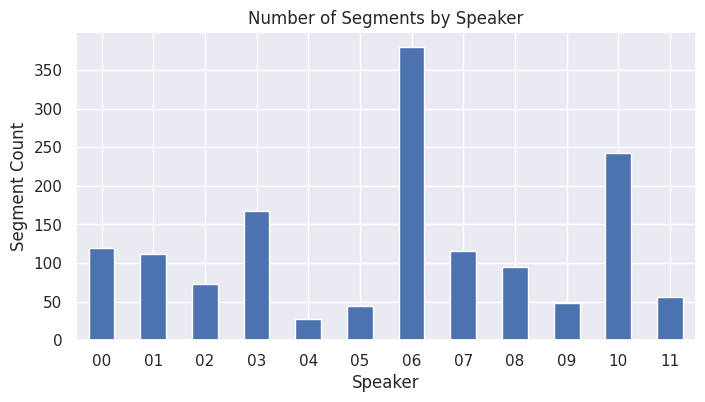

In [37]:
# Count how many words each speaker has
segment_counts = word_df['speaker'].value_counts().sort_index()

# Remove "SPEAKER_" prefix from the index (e.g., "SPEAKER_04" -> "04")
segment_counts.index = segment_counts.index.str.replace('SPEAKER_', '')

# Plot the result
segment_counts.plot(kind='bar', figsize=(8,4), title="Number of Segments by Speaker")
plt.xlabel("Speaker")
plt.xticks(rotation=0)
plt.ylabel("Segment Count")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


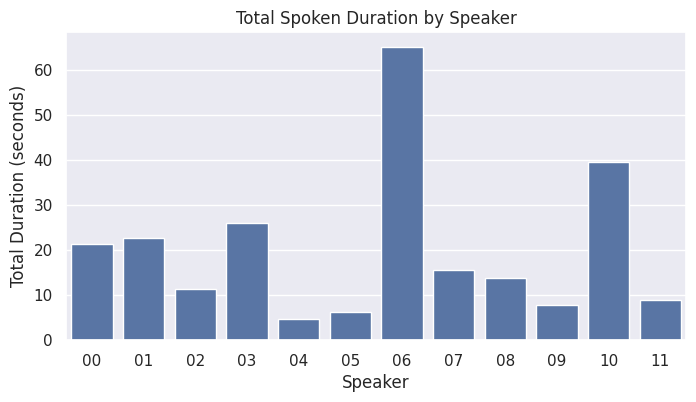

In [39]:
# Calculate the duration for each word
word_df['duration'] = word_df['end'] - word_df['start']
word_duration = word_df.groupby('speaker', as_index=False)['duration'].sum()
word_duration['speaker'] = word_duration['speaker'].str.replace('SPEAKER_', '')

plt.figure(figsize=(8, 4))
sns.barplot(data=word_duration, x='speaker', y='duration')
plt.title("Total Spoken Duration by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Total Duration (seconds)")
plt.show()

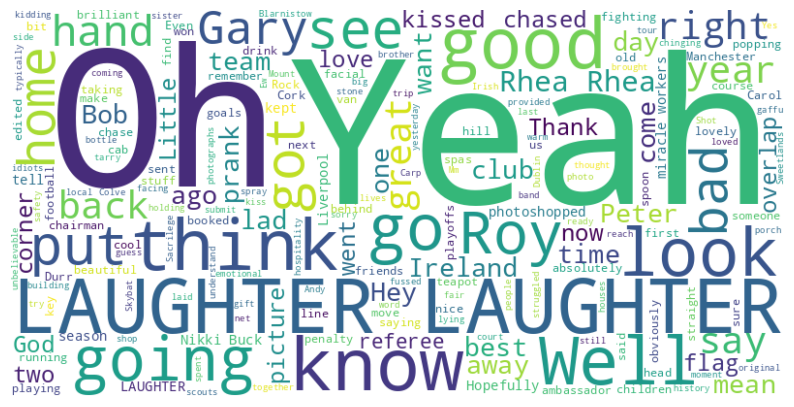

In [18]:
# Generate a Word Cloud for all speakers
all_text = " ".join(word_df["word"].values)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Word Cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

---

### **3. Leverage a Large Language Model**

---

Using Llama [4][5]

In [20]:
system_prompt = """
Summarise:
    Provide an overview of the topics discussed. What is the conversation of?

Identify Key Points:
    Highlight significant claims or issues raised by each speaker. Can you identify each speaker?

Analyse Rhetoric:
    Examine the tone and style.

Instruction:
Using the above steps, analyse the transcript, focusing on key insights and subject matter.
"""

In [21]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"

pipe = transformers_pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": conversation},
]
outputs = pipe(
    messages,
    max_new_tokens=1024,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [22]:
llm_output = outputs[0]["generated_text"][-1]["content"]
print(llm_output)

**Overview of the conversation:**
The conversation appears to be a casual gathering of friends, possibly from a football (soccer) team. They are discussing their past experiences, memories, and pranks played during their playing careers. The conversation is lighthearted, humorous, and includes some references to Irish culture and traditions.

**Identify Key Points:**
Some significant claims or issues raised by each speaker include:

* Roy and the others discuss a past incident where Roy chased someone down, and there is a debate about whether it was a bad incident or not.
* Roy and the others talk about a photo that was edited, and there is a discussion about whether it was photoshopped or not.
* The conversation also includes discussions about the team's past experiences, pranks played, and memories of their playing careers.
* Some speakers mention their experiences playing for the same team, including mentions of their time in the League of Ireland.

**Analyse Rhetoric:**
The tone of

### **Sentiment Analysis**

Using RoBERTa [7]

In [23]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [24]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [25]:
data = []
# Loop through each segment(sentence) and extract text and speaker
for segment in result['segments']:
    text = segment['text']
    speaker = segment['speaker']
    data.append({"Text": text, "Speaker": speaker})

sentence_df = pd.DataFrame(data)
sentence_df = sentence_df.reset_index().rename(columns={'index': 'id'})
print(sentence_df)

      id                                               Text          Speaker
0      0   The overlap on tour is brought to you by Skybat.       SPEAKER_10
1      1   Even that time, Roy, when you chased down Dur...       SPEAKER_07
2      2          so you didn't put a hand on him, did you?       SPEAKER_07
3      3                                        No, no, no.       SPEAKER_07
4      4        I didn't think it was that bad at the time.       SPEAKER_07
..   ...                                                ...              ...
307  307                        I look at class as a prank.       SPEAKER_00
308  308                                           LAUGHTER       SPEAKER_00
309  309                                           LAUGHTER       SPEAKER_04
310  310                                           LAUGHTER       SPEAKER_04
311  311                                           LAUGHTER  UNKNOWN_SPEAKER

[312 rows x 3 columns]


In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [27]:
res = {}
for i, row in tqdm(sentence_df.iterrows(), total=len(sentence_df)):
    try:
        # Use index directly instead of accessing the 'Id' column
        myid = row.name  # DataFrame index
        text = row['Text']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/312 [00:00<?, ?it/s]

In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(sentence_df, how='left')

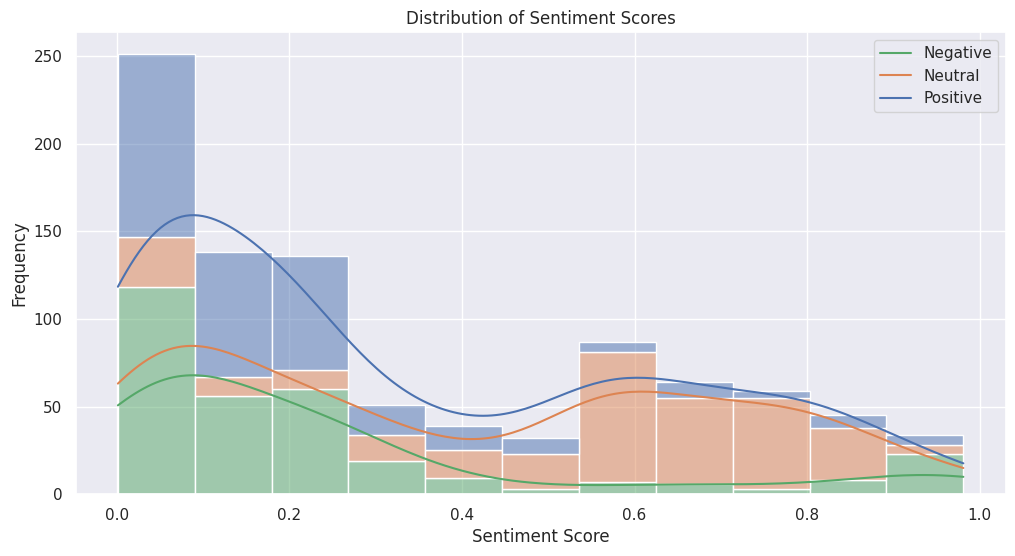

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']], kde=True, multiple="stack")
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend(['Negative', 'Neutral', 'Positive'])
plt.show()

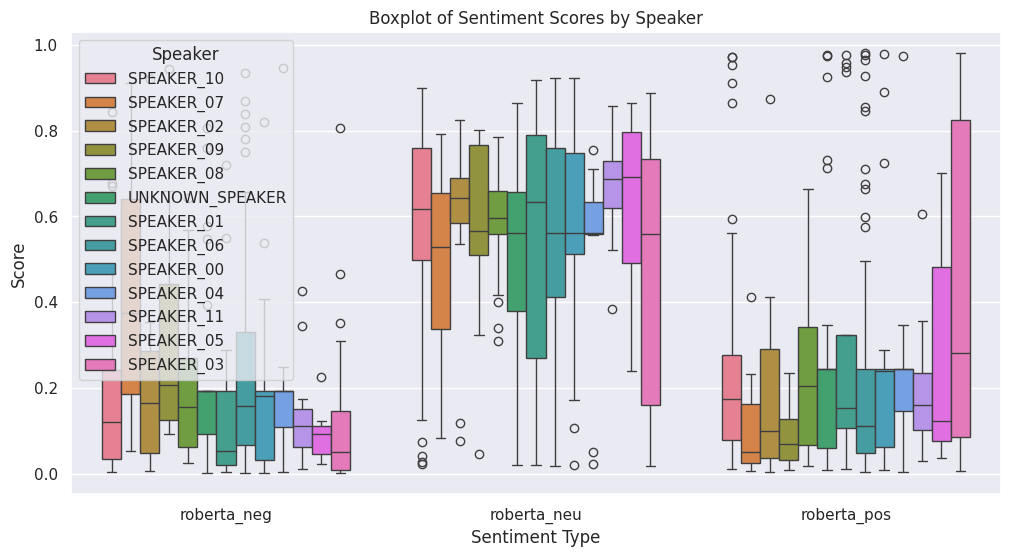

In [30]:
# 2. Boxplot of sentiment scores grouped by speaker
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df.melt(id_vars=['Speaker'], value_vars=['roberta_neg', 'roberta_neu', 'roberta_pos']),
            x='variable', y='value', hue='Speaker')
plt.title("Boxplot of Sentiment Scores by Speaker")
plt.xlabel("Sentiment Type")
plt.ylabel("Score")
plt.legend(title="Speaker")
plt.show()

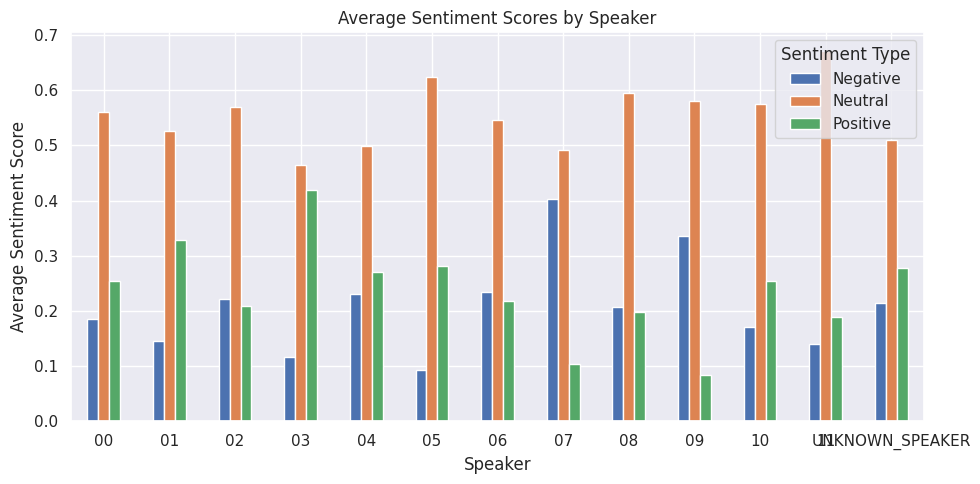

In [40]:
# Grouping by Speaker and calculating mean sentiment scores
speaker_sentiment_summary = results_df.groupby('Speaker')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

# Remove "SPEAKER_" prefix from the index
speaker_sentiment_summary = speaker_sentiment_summary.rename(index=lambda x: x.replace('SPEAKER_', ''))

speaker_sentiment_summary.plot(kind='bar', figsize=(10, 5))
plt.title("Average Sentiment Scores by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Average Sentiment Score")
plt.legend(["Negative", "Neutral", "Positive"], title="Sentiment Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [32]:
# Most positive and negative statements
most_positive = results_df.loc[results_df["roberta_pos"].idxmax()]
most_negative = results_df.loc[results_df["roberta_neg"].idxmax()]

In [33]:
most_positive

id                             108
roberta_neg               0.002141
roberta_neu               0.016819
roberta_pos                0.98104
Text            Thank you so much.
Speaker                 SPEAKER_06
Name: 108, dtype: object

In [34]:
most_negative

id                                         76
roberta_neg                          0.947118
roberta_neu                          0.049192
roberta_pos                           0.00369
Text            She's not nice in the bottle.
Speaker                            SPEAKER_04
Name: 76, dtype: object

---

### **4. Testing & Evaluation**

---

In [35]:
avg_scores = word_df.groupby('speaker')['score'].mean()
avg_scores

speaker
SPEAKER_00    0.381605
SPEAKER_01    0.531036
SPEAKER_02    0.347945
SPEAKER_03    0.397071
SPEAKER_04    0.300630
SPEAKER_05    0.317244
SPEAKER_06    0.377034
SPEAKER_07    0.348750
SPEAKER_08    0.441568
SPEAKER_09    0.522771
SPEAKER_10    0.415264
SPEAKER_11    0.448625
Name: score, dtype: float64

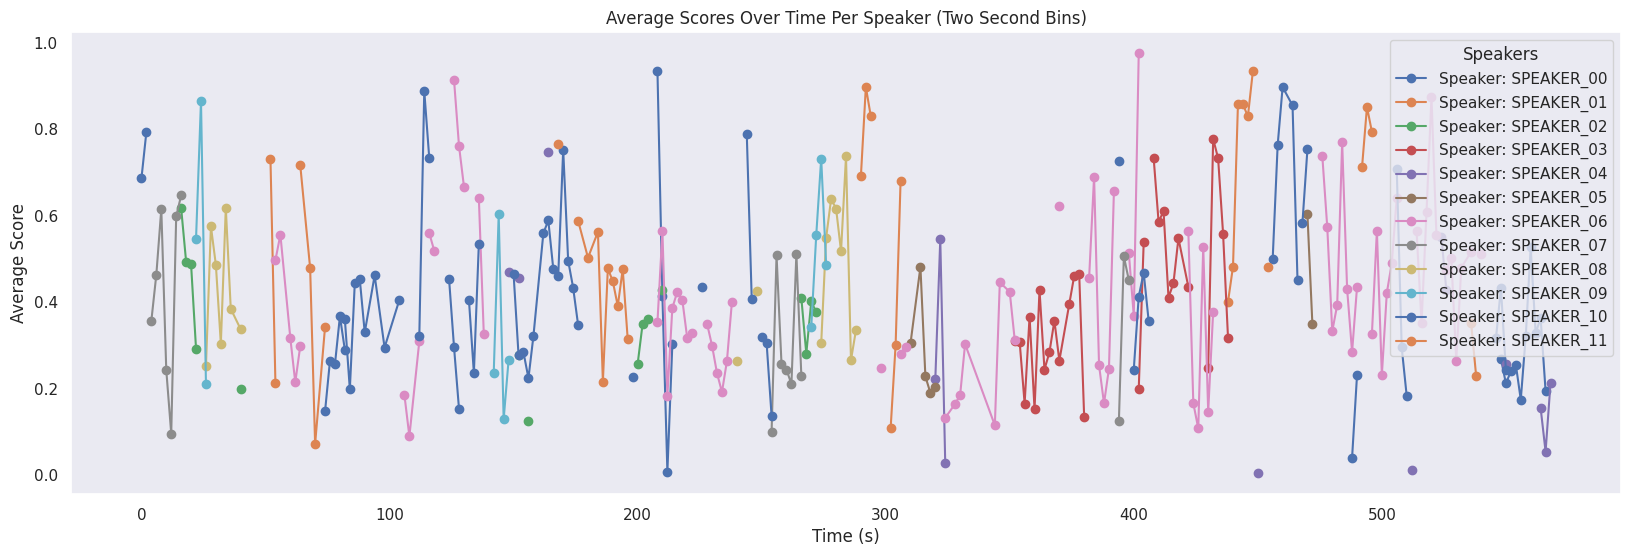

In [36]:
# Create two second time bins
word_df['time_bin'] = np.floor(word_df['start'] / 2) * 2

binned_scores = word_df.pivot_table(
    index='time_bin', columns='speaker', values='score', aggfunc='mean'
)

# Plotting the average scores over time per speaker
plt.figure(figsize=(20, 6))
for speaker in binned_scores.columns:
    plt.plot(binned_scores.index, binned_scores[speaker], marker='o', label=f'Speaker: {speaker}')

plt.xlabel('Time (s)')
plt.ylabel('Average Score')
plt.title('Average Scores Over Time Per Speaker (Two Second Bins)')
plt.legend(title='Speakers')
plt.grid()
plt.show()

### **Conclusion**

- The file did a pretty ok job at speaker diarisation and transcription. The scoring is not very high due to overlapping speakers in the audio file as shown in the scores above.

- The LLM summarised the file well enough. It deciphered that it was friends speaking about football. It correctly determined the tone.

- The sentiment analysis showed that the audio was skewed to neutral with speaker 7, Gary Neville, being the most negative.


---

### **References**

1. Hugging Face (n.d.). *pyannote/segmentation*. Available at: [https://huggingface.co/pyannote/segmentation](https://huggingface.co/pyannote/segmentation) (Accessed: 13 January 2025).
2. pyannote (n.d.). *pyannote-core reference*. Available at: [http://pyannote.github.io/pyannote-core/reference.html#annotation](http://pyannote.github.io/pyannote-core/reference.html#annotation) (Accessed: 20 December 2024).
3. OpenAI (n.d.). *Whisper*. Available at: [https://github.com/openai/whisper](https://github.com/openai/whisper) (Accessed: 20 December 2024).
4. Meta (n.d.). *llama-models*. Available at: [https://github.com/meta-llama/llama-models](https://github.com/meta-llama/llama-models) (Accessed: 20 December 2024).
5. Meta (n.d.). *Llama-3.2-3B-Instruct*. Available at: [https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) (Accessed: 20 December 2024).
6. Bain, M. (n.d.). *whisperX*. Available at: [https://github.com/m-bain/whisperX](https://github.com/m-bain/whisperX) (Accessed: 21 December 2024).
7. Mulla, R. (n.d.) Python Sentiment Analysis Project with NLTK and Transformers. Classify Amazon Reviews!!. Available at: https://www.youtube.com/watch?v=QpzMWQvxXWk (Accessed: 20 December 2024).

---

# END